### Import

In [ ]:
import gzip
import json
import random
import time
from nltk import word_tokenize
from tqdm import tqdm
import contractions

# Imports for the synonym dictionary 
import requests
from bs4 import BeautifulSoup
from nltk.wsd import lesk

#wordnet imports
#importing NLTK corpus synonym dictionary, pos-tagging and checking the outputs
import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
import random


from sklearn.utils import shuffle

#Word2Vec imports
import gensim.models

In [ ]:
#wordnet downloads
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
random.seed(42)

### Read in the data

In [ ]:
#here
def reading_in(path):
    thing=[]
    for line in gzip.open(path):
        review_data = json.loads(line)
        subthing = dict()
        for key in review_data:
            subthing[key]= review_data[key]
        thing.append(subthing)
    return thing

In [ ]:
train = reading_in('../data/classification/music_reviews_train.json.gz')
#dev = reading_in('../data/classification/music_reviews_dev.json.gz') # do not use!
#test = reading_in('../data/classification/music_reviews_test_masked.json.gz') #do not use!
train = shuffle(train, random_state=42)

In [ ]:
train_x = [i['reviewText'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]
train_y =  [i['sentiment'] for i in train if "reviewText" in i.keys() and "sentiment" in i.keys()]

In [ ]:
pos_neg = [sum([i =="positive" for i in train_y]),sum([i != "positive" for i in train_y])]

<BarContainer object of 2 artists>

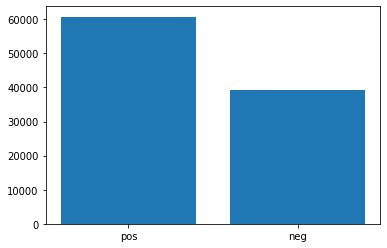

In [ ]:
import matplotlib.pyplot as plt
plt.bar(x=["pos","neg"], height = pos_neg) 

In [ ]:
###split into pos and neg
train_x_pos = []
train_x_neg = []
train_y_pos = []
train_y_neg = []
for i in range(len(train_x)):
    if train_y[i] == "positive":
        train_x_pos.append(train_x[i])
        train_y_pos.append(train_y[i])
    else:
        train_x_neg.append(train_x[i])
        train_y_neg.append(train_y[i])
train_x_neg.extend(train_x_pos[0:len(train_x_neg)])
train_y_neg.extend(train_y_pos[0:len(train_y_neg)])
balanced_x_train_s = train_x_neg
balanced_y_train_s = train_y_neg

balanced_x_train, balanced_y_train = shuffle(balanced_x_train_s, balanced_y_train_s, random_state= 42)


In [ ]:
len(balanced_x_train)

78424

### Preparing the data

In [ ]:
#old tokenizer
#train_x_back = [' '.join(sen) for sen in train_x_split] may not need convertes tokenised back to single string

In [ ]:
#Tokenizer
def tokenize_corpus(corpus):
    return [word_tokenize(contractions.fix(s)) for s in corpus]

In [ ]:
train_x_split = tokenize_corpus(balanced_x_train)

# Webscrape synonyms

In [ ]:
##Alternative to PyDictionary
##THIS IS COPIED FROM SLACK
# https://stackoverflow.com/questions/52910297/pydictionary-word-has-no-synonyms-in-the-api

def synonyms(term):
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.text, 'lxml')
    soup.find('section', {'class': 'css-17ofzyv e1ccqdb60'})
    return [span.text for span in soup.findAll('a', {'class': 'css-1kg1yv8 eh475bn0'})] # 'css-1gyuw4i eh475bn0' for less relevant synonyms

word = "us"
print(synonyms(word))

['them ', 'you ']


In [ ]:
dont_replace = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will','i', 'it', 'she', 'sie', 'they', 've', 'xe', 'you', 'ze', 'zie','he',"you","we","mine","hers","his","yours","its","ours","theirs","your","our","oneself","oneselves","yourself","yourselves","himself","herself","himself","myself","themselves","itself","ourselves","ourself","us","them"] #Used to avoid changing function and pronouns words
random.seed(43)
def gen_synth_web(sentence,prob = 0.5):
    new_sen = []
    for word in sentence:
        if word.lower() in dont_replace:
            new_sen.append(word)
        else:
            if prob < random.random():
                #print(threshold) can remove later kept for debugging
                syn = synonyms(word.lower())
                if len(syn) != 0:
                    #print("selected", word) can remove later kept for debugging
                    new_sen.append(random.choice(syn))
                else:new_sen.append(word)
            else:
                new_sen.append(word)
    return new_sen

In [ ]:
print(train_x_split[11])

['I', 'love', 'this', 'song', ',', 'words', 'and', 'music', 'is', 'on', 'point']


In [ ]:
print(gen_synth_web(train_x_split[11]))

['I', 'worship ', 'this', 'song', ',', 'words', 'and', 'music', 'is', 'on', 'point']


In [ ]:
[0,1,2,3,4][:2]

[0, 1]

In [ ]:
for i in tqdm(train_x_split[0:10000]):#running with 0:10000
    with open ("../data/synthetic/webscrape.csv","a") as f:
        f.write(' '.join(gen_synth_web(i))+"\n")
        time.sleep(2)

100%|██████████| 10000/10000 [15:37:54<00:00,  5.63s/it]


#### Example of webscrape synthetic sentence 

In [ ]:
print(train_x_split[6])

['I', 'love', 'all', 'of', 'his', 'music', '!', '!']


In [ ]:
print(gen_synth_web(train_x_split[6]))

['I', 'passion ', 'fully ', 'of', 'his', 'music', '!', '!']


# Wordnet

In [ ]:
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
wordnet_tag_map = {'NN': ['n'],'NNS': ['n'],'JJ': ['a'],'JJR': ['a'],'JJS': ['a'],'RB': ['r'],'RBR': ['r'],'RBS': ['r'], 'VB': ['v'], 'VBG': ['v'], 'VBD': ['v'], 'VBN': ['v'], 'VBP': ['v'], 'VBZ': ['v']} #Making pos-tags coincide
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_wordnet(sentence):
    sentence = nltk.pos_tag(sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if random.random()>0.5:
            if word[1] in relevant and word[0] not in aux_verbs: #Not changing functional words
                tag = wordnet_tag_map[word[1]]
                chosen = lesk(sentence, word[0], tag[0]) #from all synsets choose the most likely in a smart way, thanks to library!
                if chosen is None:
                    new_sentence.append(word[0]) #sometimes no synset is chosen so we just give the new sentence the original word
                else:
                    options = chosen.lemma_names()
                    if word[0] in options:
                        options.remove(word[0])
                    if len(options)>0:
                        chosen_w = random.choice(options)
                        if "_" in chosen_w:
                            for w in chosen_w.split("_"):
                                new_sentence.append(w)
                        else:
                            new_sentence.append(chosen_w)
                    else:
                        new_sentence.append(word[0])
            else:
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

#### Example of wordnet synthetic sentence 

In [ ]:
print(train_x_split[3])

['I', 'love', 'the', 'sound', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']


In [ ]:
print(change_wordnet(train_x_split[3]))

['I', 'love', 'the', 'strait', 'of', 'anything', 'George', 'Ezra', 'sings', 'in', ';', 'remarkable', 'young', 'man', '.']


#### write to file

In [ ]:
wn_x_train = [change_wordnet(i) for i in train_x_split]

In [ ]:
with open("../data/synthetic/wordnet.csv",'w') as f:
    f.writelines('\t'.join(s) + '\n' for s in wn_x_train)

# Word2vec

In [ ]:
gooEmbs = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-50k.bin', binary=True)
print('loading finished')

loading finished


In [ ]:
gooEmbs.most_similar('run')

[('runs', 0.6569936275482178),
 ('running', 0.6062965989112854),
 ('drive', 0.4834049642086029),
 ('ran', 0.4764978289604187),
 ('scamper', 0.46932122111320496),
 ('go', 0.4631645083427429),
 ('walk', 0.45697975158691406),
 ('homerun', 0.45180249214172363),
 ('roundtripper', 0.43272683024406433),
 ('sacrifice_fly', 0.42050617933273315)]

In [ ]:
# With a threshold and without the check of same word

gooEmbs = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-50k.bin', binary=True)
print('loading finished')
relevant = ["NN","NNS","RB","RBR","RBS","VB","VBG","VBD","VBN","VBP","VBZ","JJ","JJR","JJS"]#The wordclasses that can be exchanged with synonyms (not functional words) #maybe not RB
aux_verbs = ['am','are','be','been','being','did','do','does','had','has','have','having','is','was','were','will'] #Used to avoid changing function words
def change_word2vec(original_sentence, prob = 0.5, threshold = .6):
    sentence = nltk.pos_tag(original_sentence)    #pos-tagging sentence here
    new_sentence = [] #to append to and then return as final sentence
    for word in sentence:
        if word[1] in relevant and word[0] not in aux_verbs:
            if random.random() > prob:
                try:
                    syno = gooEmbs.most_similar(word[0]) #taking the most similar word from word2vec
                    syno_pos = []
                    # method 1: 
                    for s in syno:
                        if s[1] > threshold:
                            syno_pos.append(s)
                        else: 
                            break # because all the words are sorted we know that if one word is under 60% all the others after are also
                    if syno_pos!=[]:
                        new_word = random.choice(syno_pos)[0]
                    else:  new_word = syno[0][0]
                    if "_" in new_word:
                        for w in chosen_w.split("_"):
                            new_sentence.append(w)
                    else: new_sentence.append(new_word)                    
                except:
                    new_sentence.append(word[0])
            else: 
                new_sentence.append(word[0])
        else:
            new_sentence.append(word[0])
    return new_sentence

loading finished


#### Write to file

In [ ]:
wn_x_train = [change_word2vec(i) for i in tqdm(train_x_split[:25000])]
with open("../data/synthetic/word2vec.csv",'w') as f:
    f.writelines('\t'.join(s) + '\n' for s in wn_x_train)




100%|██████████| 25000/25000 [7:16:52<00:00,  1.05s/it]


In [ ]:
print(change_word2vec(train_x[1]))
len(train_x)

['This', 'tapes', 'can', 'scarcely', 'be', 'understood', 'and', 'it', 'was', 'listing', 'for', 'sold', 'as', '``', 'very', 'good', "''", '.', 'It', "'s", 'VERY', 'BAD', '.']


99946

In [ ]:
#new_x = []
#for  i in train_x[:1000]:
    #new_x.append(change_word2vec(i))

In [ ]:
print(train_x_split[6])
print(gen_synth_web(train_x_split[6]))
print(change_wordnet(train_x_split[6]))
print(change_word2vec(train_x_split[6]))

['I', 'love', 'all', 'of', 'his', 'music', '!', '!']
['ve ', 'love', 'group ', 'of', 'his', 'music', '!', '!']
['I', 'have_intercourse', 'all', 'of', 'his', 'music', '!', '!']


UnboundLocalError: local variable 'sentence' referenced before assignment

# Baseline

In [ ]:
pipeline = Pipeline([
    ('CountVectorizer',CountVectorizer(ngram_range=(1, 2))),
    ('Tfidf',TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1, fit_prior=False))
])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b88dfe01-c7e1-473c-bcfd-798313fc6522' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>